### Dataset perprocessing

In [5]:
import nltk, razdel
from nltk.tokens import stopwords
from pymystem3 import Mystem
import string, regex as re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Download nltk packages used in this example
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /home/aliak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/aliak/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [36]:
# Customize list of stopwords as needed. Here, we append common
# punctuation and contraction artifacts.
with open('../aux/stopwords-ru.txt', 'r') as f:
    ru_stop_words_extensive = f.read().splitlines()
    
punctuations = list(string.punctuation) + ["—", "«", "»"]
stop_words = list(set(ru_stop_words_extensive + stopwords.words('russian'))) + punctuations

In [117]:
df = pd.read_json("../dataset/shuffled_hashed_rbc_dataset.json")
df = df.transpose()
df.reset_index()

In [234]:
def get_article_sentences(article_text):
    sentences = list()
    for sentence in razdel.sentenize(article_text):
        sentences.append(sentence.text)
    return sentences

In [235]:
def get_article_tokens(article_text):
    tokens = list()
    article_sentences = get_article_sentences(article_text)
    for sentence in article_sentences:
        for token in razdel.tokenize(sentence):
            if token.text not in stop_words:
                tokens.append(token.text.lower())
    return tokens

In [236]:
def get_article_lemmas(article_text):
    mystem = Mystem()
    lemmas = set()
    
    article_sentences = get_article_sentences(article_text)
    for sentence in article_sentences:
        lemmas.add(mystem.lemmatize(sentence.lower()))
        
    lemmas = [lemma for lemma in lemmas if lemma not in stop_words\
          and lemma != " " \
          and lemma.strip() not in punctuations]
    return lemmas

### Preproccessing

In [207]:
mystem = Mystem()
#Preprocess function
def informative_preprocess_annotation(sentence):
    lemmas = mystem.lemmatize(sentence.lower())
    sentence_info = mystem.analyze(sentence)
    analysis_info = list(filter(lambda x: 'analysis' in x, sentence_info))
    
    lemmas = [lemma for lemma in lemmas if lemma not in stop_words\
              and lemma != " " \
              and lemma.strip() not in punctuations]

    sentence = " ".join(lemmas)
    processed_sentence = [word for word in sentence.split(' ')]

    return (processed_sentence, analysis_info)

### Article statistics

In [ ]:
def text_stats(text):
    sentences = get_article_sentences(text)
    tokens = get_article_tokens(text)
    fdist = nltk.FreqDist(tokens)
    return sentences, tokens, fdist

### Analyzing article statistics

In [232]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

def text_stats_analysis(article):
    
    article_text = article['article_text']
    article_annotation = article['article_overview']
    sentences, tokens, fdist =  text_stats(article_text)
    
    num_words = sum([i for i in fdist.values()])
    num_unique_words = len(fdist.items())

    average_word_length = round(sum(len(word) for word in tokens) / len(tokens), 2)
    max_word_length = np.max(np.array([len(word) for word in tokens]))
    average_sentence_length = round(len(tokens) / len(sentences), 2)

    # Hapaxes are words that appear only once
    num_hapaxes = len(fdist.hapaxes())
    top_n_words = fdist.most_common(10)
        
    print('\tMaximum word length in article text:'.ljust(25), max_word_length)
    print('\tAverage length of a word (letterwise):'.ljust(25), average_word_length)
    print('\tAverage length text length(wordwise):'.ljust(25), average_sentence_length)
    print('\tNum Sentences:'.ljust(25), len(sentences))
    print('\tNum Words:'.ljust(25), num_words)
    print('\tNum Unique Words:'.ljust(25), num_unique_words)
    print('\tNum Hapaxes:'.ljust(25), num_hapaxes)
    print('\tTop 10 Most Frequent Words (stop words):\n\t\t', \
            '\n\t\t'.join(['%s (%s)'
            % (w[0], w[1]) for w in top_n_words]))
    print("-----------------------------------------------------------------")
    data = []

    for word,freq in fdist.most_common(10):
        data.append({'Word':word,'Frequency':freq})

    df = pd.DataFrame(data)

    # Create a bar graph with the most commonly used descriptors
    df['Word']=df['Word'].str.capitalize()
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    df.plot(kind='barh', x='Word',y='Frequency', ax=axes[0], figsize=(15,5),color='#cb101c')
    df.plot(kind='line', x='Word',y='Frequency', ax=axes[1], figsize=(15,5))

### Extractive generation of article annotation:
At the start of each news article in the RBC dataset, there is the headline at first, then an annotation(overview) on the article itself, we use extractive techniques to construct an alternative annotation, then we compare it with the original one.

In [219]:
def _score_sentences(sentences, important_words):
    N = 3
    CLUSTER_DIST = 3
    scores = []
    sentence_idx = -1

    for s in [nltk.tokenize.word_tokenize(s) for s in sentences]:

        sentence_idx += 1
        word_idx = []
        
        for w in important_words:
            try:
                word_idx.append(s.index(w[0]))
            except ValueError:
                pass

        word_idx.sort()

        if len(word_idx)== 0: continue
        clusters = []
        cluster = [word_idx[0]]
        i = 1
        while i < len(word_idx):
            if word_idx[i] - word_idx[i - 1] < CLUSTER_DIST:
                cluster.append(word_idx[i])
            else:
                clusters.append(cluster[:])
                cluster = [word_idx[i]]
            i += 1
        clusters.append(cluster)

        max_cluster_score = 0
        for c in clusters:
            significant_words_in_cluster = len(c)
            total_words_in_cluster = c[-1] - c[0] + 1
            score = 1.0 * significant_words_in_cluster \
                * significant_words_in_cluster / total_words_in_cluster

            if score > max_cluster_score:
                max_cluster_score = score

        scores.append((sentence_idx, score))

    return scores

In [220]:
def pick_top_annotations_by_score(article, NUM_OF_TOP_WORDS):
    
    sentences = get_article_sentences(article_text)
    tokens = get_article_tokens(article_text)
    article_annotation = article['article_overview']
    top_n_words = fdist.most_common(NUM_OF_TOP_WORDS)
    normalized_sentences = [s.lower() for s in sentences]
    NUM_TOP_SCORED_annotationS = 5  # Number of sentences to return for a "top n" summary
    scored_sentences = _score_sentences(normalized_sentences, top_n_words)

    # Extractive Approach 1:
    # Filter out nonsignificant sentences by using the average score plus a
    # fraction of the std dev as a filter

    avg = np.mean([s[1] for s in scored_sentences])
    std = np.std([s[1] for s in scored_sentences])
    mean_scored = [(sent_idx, score) for (sent_idx, score) in scored_sentences
                   if score > avg + 0.5 * std]

    # Extractive Approach 2:
    # Another approach would be to return only the top N ranked sentences

    top_n_scored = sorted(scored_sentences, key=lambda s: s[1])[-NUM_TOP_SCORED_annotationS:]
    top_n_scored = sorted(top_n_scored, key=lambda s: s[0])
    
    print("\n"*3)
    print("------------Original Annotation-----------------------------------")
    print(article_annotation)
    print("-"*60)
    print("-------Annotations(Picked/blue -- original/black)--------")
    top_n_summary=[sentences[idx] for (idx, score) in top_n_scored]
    mean_scored_summary=[sentences[idx] for (idx, score) in mean_scored]
    for sen in sentences:
        # If both approaches of extraction lead to the same sentence then we accept it 
        if (sen) in set(mean_scored_summary and top_n_summary):
            print("\x1b[94m"+sen+"\x1b[0m"+"\t")
        else:
            # We print the original sentence
            print(sen)
    print("-------------------------------------------------------")
    for (idx, score) in mean_scored:
        print(sentences[idx], score)
    print("------------------------------------------------------")
    print("-------------------Lemmatized text--------------------")
    print("------------------------------------------------------")
    for top_sentence in top_n_summary:
        lemmatized_sentence, analysis_info = informative_preprocess_annotation(top_sentence)
        print("Original =>\t"+top_sentence)
        print("Preprocessed =>\t"+"\x1b[35m" +' '.join(lemmatized_sentence) +"\x1b[0m")
#         for i in analysis_info:
#             print("word-info:", i['analysis'], i['text'])
#         print("=================================================")
    print("-----------------------------------------------------")

	Maximum word length in article text: 16
	Average length of a word (letterwise): 7.24
	Average length text length(wordwise): 19.25
	Num Sentences:           12
	Num Words:               231
	Num Unique Words:        167
	Num Hapaxes:             130
	Top 10 Most Frequent Words (stop words):
		 рнпк (6)
		reuters (5)
		танкеров (5)
		россии (4)
		российских (4)
		морских (4)
		страхования (4)
		p (4)
		i (4)
		стала (3)
-----------------------------------------------------------------




------------Original Annotation-----------------------------------
РНПК стала ключевым перестраховщиком российских танкеров, сообщил Reuters. Ранее ЕС запретил страхование и перестрахование морских перевозок российской нефти в третьи страны и, как пишет FT, согласовал этот запрет с Британией
------------------------------------------------------------
-------Annotations(Picked/blue -- original/black)--------
Reuters назвал нового главного перестраховщика танкеров из России Reuters узнал, что РНПК стала

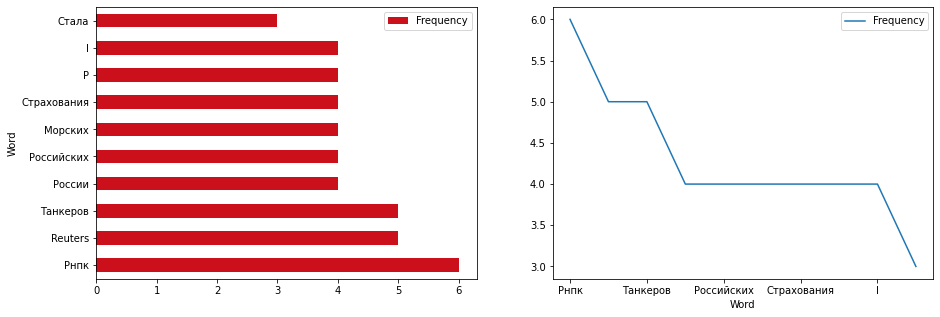

In [231]:
for index, article in df.iterrows():
    text_stats_analysis(article)
    pick_top_annotations_by_score(article, 5)
    break

In [1]:
import pandas as pd

In [3]:
df_bart = pd.read_csv('../outputs/mbart/mbart_gen_summary_ref_summary_full_text.csv')
df_t5 = pd.read_csv('../outputs/t5/predictions_headline_article_text.csv')

In [7]:
df_bart.head(3)

,Unnamed: 0,gen_summary,ref_summary,full_text
0,0,В Запорожскую область отправлено 11 вагонов с ...,Песков заявил об отсутствии соглашений по укра...,Об отправке 11 вагонов с зерном для продажи ...
1,1,Владимир Зеленский «не хотел слышать» предупре...,В Киеве попросили уточнить слова Байдена об от...,Западные страны не стали вводить превентивны...
2,2,В случае дефолта «Роснано» для всех госкомпани...,Владелец бондов «Роснано» назвал возможный деф...,"По мнению гендиректора «Арикапитала», если г..."


In [8]:
df_t5.head(3)

,Unnamed: 0,gen_summary,ref_summary,Full_Text
0,0,Умер бывший сотрудник спецподразделения «Альфа...,Умер убивший афганского диктатора Амина спецна...,Амин получил смертельное ранение осколком гран...
1,1,Власти увеличат объем финансирования на развит...,"На город Спутник потратят более 15,5 млрд руб.","Правительство потратит более 15,5 млрд руб. на..."
2,2,Турция начала укладывать газопровод в акватори...,Эрдоган объявил о начале укладки газопровода п...,"Месторождение Сакарья, из которого будут поста..."


In [26]:
r = []
for i in range(len(df_t5.index)):
    for j in range(len(df_bart.index)):
        if df_t5['ref_summary'][i] == df_bart['ref_summary'][j]:
            r.append(["T5 Hypothesis:" + df_t5['gen_summary'][i], "mBART Hypothesis:" + df_bart['gen_summary'][j],  "Source:" + df_bart['ref_summary'][j]])

In [33]:
r[74]

['T5 Hypothesis:MasterCard обнулила комиссии за переводы с карты на карту по номеру телефона',
 'mBART Hypothesis:Вслед за Mastercard Visa пошла на отказ от комиссий за переводы с карты на карту по',
 'Source:Visa отменит комиссию за переводы с карты на карту по номеру телефона']